# ESM vs WOA

#### Dask Import

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39610")
client

Client Scheduler: tcp://127.0.0.1:39610 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 25.77 GB


<br>

#### Choices for data

In [2]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceID = 'E3SM-1-0'

#Custom Variables
latSel = slice(-89.5,-29.5) #Selected latitude to be investigated

<br>

#### Importing Libaries

In [3]:
import cartopy.crs as ccrs
import dask.dataframe as dd
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm
print("Imports complete")

Imports complete


<br>

#### Data Loading

<b>WOA Data</b>

In [4]:
def WOAOpen(dsLink):
    dsWOA = pd.read_csv(dsLink, skiprows =1,index_col=[0,1])
    dsWOA = dsWOA.rename({' AND VALUES AT DEPTHS (M):0':'0'}, axis='columns')
    dsWOAm = pd.melt(dsWOA,var_name = 'LEVEL', value_name = 'TEMPERATURE', ignore_index = False)
    dsWOAm = dsWOAm.astype({'LEVEL':int})
    dsWOAm = dsWOAm.set_index('LEVEL', append = True)
    dsName = str(dsLink)[6:-4]
    print("WOA data for "+dsName+" successfully loaded and arranged in pd.")
    return dsWOAm

def WOAConvert(dsWOA, name):
    dfWOA = dsWOA.to_xarray()
    dfWOA = dfWOA.rename({'COMMA SEPARATED LATITUDE':'lat', ' LONGITUDE':'lon', 'LEVEL':'lev'})
    dfWOALat = dfWOA.sel(lat=latSel)
    dfWOALat = dfWOALat.to_array()
    dfWOALat = dfWOALat.rename(name)
    print("WOA data for "+ dfWOALat.name+" successfully converted to xr and lat filtered.")
    return dfWOALat

def WOAOpenConv(dsLink):
    dfName = str(dsLink)[6:-4]
    return WOAConvert(WOAOpen(dsLink),dfName)

print("WOA handling functions defined")

WOA handling functions defined


In [5]:
dfWOALatDecav = WOAOpenConv("woa18_decav_t00mn01.csv") #Decadal average
dfWOALatCmean = WOAOpenConv("woa18_A5B7_t00an01.csv") #Climatological mean
dfWOALatSmean = WOAOpenConv("woa18_A5B7_t00mn01.csv") #Statistical mean

WOA data for decav_t00mn01 successfully loaded and arranged in pd.
WOA data for decav_t00mn01 successfully converted to xr and lat filtered.
WOA data for A5B7_t00an01 successfully loaded and arranged in pd.
WOA data for A5B7_t00an01 successfully converted to xr and lat filtered.
WOA data for A5B7_t00mn01 successfully loaded and arranged in pd.
WOA data for A5B7_t00mn01 successfully converted to xr and lat filtered.


<br>
<b>ESM Data</b>

In [6]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
dfFilt = df[df.variable_id.eq('thetao') & df.experiment_id.eq('historical') & df.source_id.eq('E3SM-1-0')]
dfArea = df[df.variable_id.eq('areacello') & df.source_id.eq('CESM2')]

fileSetList = []
for i in range(len(dfFilt)):
    zstore = dfFilt.zstore.values[i]
    mapper = fsspec.get_mapper(zstore)
    fileRaw = xr.open_zarr(mapper, consolidated=True)
    fileSetList.append(fileRaw)
fileCount = len(fileSetList)

dsArea = xr.open_zarr(fsspec.get_mapper(dfArea.zstore.values[1]), consolidated=True)
dataAreaRaw = dsArea.areacello

for i in range(fileCount): #Formatting dates into np.datetime64 format
    startDateIterate = np.datetime64(fileSetList[i]['time'].values[0],'M')
    endDateIterate = np.datetime64(fileSetList[i]['time'].values[-1],'M') + np.timedelta64(1,'M')
    fileSetList[i]['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
    fileSetList[i]['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 
fileSet = xr.combine_nested(fileSetList, concat_dim='RunID') #Combining data sets

dfESMLat = fileSet.thetao.sel(lat=latSel) #Selection of latitude
dfESMLat = dfESMLat.reset_coords(drop=True) #Removes lev if single value

globalStartDate = dfESMLat["time"][0].values
globalDateInc = dfESMLat["time"][1].values - globalStartDate
#np.datetime64(globalDateInc,'D')
globalEndDateIn = dfESMLat["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("ESM data sucessfully loaded.")

ESM data sucessfully loaded.


<br>

#### Calculations
Functions:

In [7]:
def rangeMeanSurfaceTempESM(startDate, endDate, plotNo):
    #define data set
    subSet = dfESMLat.copy()
    subSet = subSet.sel(lev=5.0, time=slice(startDate, endDate))
    subSetClean = subSet.reset_coords(drop=True)
    subSetMeanT = subSetClean.mean('time', keep_attrs = True)
    subSetMeanTR = subSetMeanT.mean('RunID', keep_attrs = True)
    geoTempPlot(subSetMeanTR, str(startDate)+" - "+str(endDate), "ESM3", plotNo)
    
def rangeMeanSurfaceTempWOA(dfWOASet, plotNo):
    subSet = dfWOASet.copy()
    subSet = subSet.sel(lev=5.0)
    subSetClean = subSet.reset_coords(drop=True)
    geoTempPlot(subSetClean, dfWOASet.name, "WOA", plotNo)

print("Calculation functions defined")

Calculation functions defined


<br>
Maximum and minimum temperatures across all data sets for plotting limits.

In [8]:
dfSurfaceTemp = dfESMLat.copy()
dfSurfaceTemp = dfSurfaceTemp.sel(lev=5.0, time=slice('2005-01', '2014-12'))
dfSurfaceTemp = dfSurfaceTemp.reset_coords(drop=True)
dfSurfaceTemp = dfSurfaceTemp.mean('time', keep_attrs = True)
dfSurfaceTemp = dfSurfaceTemp.mean('RunID', keep_attrs = True)
surfaceTempMin = dfSurfaceTemp.min() #Sets minimum temperature for all data sets to ESM3 min
surfaceTempMin = surfaceTempMin.compute()
surfaceTempMin = round(float(surfaceTempMin.values),3)
surfaceTempMax = dfSurfaceTemp.max() #Sets minimum temperature for all data sets to ESM3 min
surfaceTempMax = surfaceTempMax.compute()
surfaceTempMax = round(float(surfaceTempMax.values),3)
print("ESM surface temp min = "+str(float(surfaceTempMin)))
print("ESM surface temp max = "+str(float(surfaceTempMax)))

WOADataList = [dfWOALatDecav, dfWOALatCmean, dfWOALatSmean]
for i in WOADataList:
    WOASurfaceData = i.sel(lev=5.0)
    WOASurfaceTempMin = WOASurfaceData.min()
    WOASurfaceTempMin = WOASurfaceTempMin.compute()
    WOASurfaceTempMax = WOASurfaceData.max()
    WOASurfaceTempMax = WOASurfaceTempMax.compute()
    print("WOA "+i.name+" surface temp min = "+str(WOASurfaceTempMin.values))
    print("WOA "+i.name+" surface temp max = "+str(WOASurfaceTempMax.values))
    if float(WOASurfaceTempMin.values) < surfaceTempMin:
        surfaceTempMin = float(WOASurfaceTempMin.values)
    if float(WOASurfaceTempMax.values) > surfaceTempMax:
        surfaceTempMax = float(WOASurfaceTempMax.values)

print("Minimum surface temperature across all data sets: "+str(surfaceTempMin))
print("Maximum surface temperature across all data sets: "+str(surfaceTempMax))

ESM surface temp min = -1.769
ESM surface temp max = 25.073
WOA decav_t00mn01 surface temp min = -2.302
WOA decav_t00mn01 surface temp max = 24.304
WOA A5B7_t00an01 surface temp min = -1.874
WOA A5B7_t00an01 surface temp max = 24.485
WOA A5B7_t00mn01 surface temp min = -2.018
WOA A5B7_t00mn01 surface temp max = 26.276
Minimum surface temperature across all data sets: -2.302
Maximum surface temperature across all data sets: 26.276


<br>

#### Plotting Functions

In [9]:
def geoTempPlot(dataSet, date, dataID, plotNo):
    '''Displays Ocean temperature for given data set on a map, prints mean ocean temperature'''
    latStep = dataSet['lat'].values[1] - dataSet['lat'].values[0]
    latend1 = dataSet['lat'].values[0] - latStep
    latend2 = dataSet['lat'].values[-1] + latStep
    plt.figure(plotNo, figsize=[7,7])
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),cmap='RdBu_r', vmin=surfaceTempMin, 
        vmax=surfaceTempMax,robust=True, subplot_kws={'projection': ccrs.SouthPolarStereo()})
    plt.plot(np.arange(0,360,1),np.ones(360)*latend1, transform=ccrs.PlateCarree(), color="Black")
    plt.plot(np.arange(0,360,1),np.ones(360)*latend2, transform=ccrs.PlateCarree(), color="Black")
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title("Southern Ocean Temp: " + str(date) + " ("+str(dataID)+")")


print("Plotting functions defined")

Plotting functions defined


<br>

#### Individual Plots

Plot of ESM3 mean surface temperature data for 2005-01 to 2014-12.

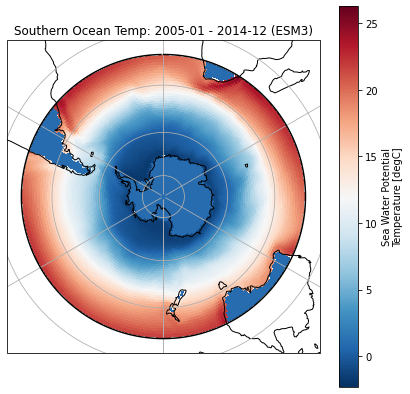

In [10]:
rangeMeanSurfaceTempESM('2005-01','2014-12',1)

Plot of WOA surface temperature data for averaged Decade years.

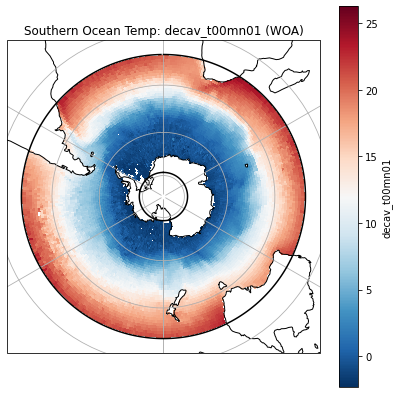

In [11]:
rangeMeanSurfaceTempWOA(dfWOALatDecav,1)

Plot of WOA clim mean surface temperature data for 2005 - 2017.

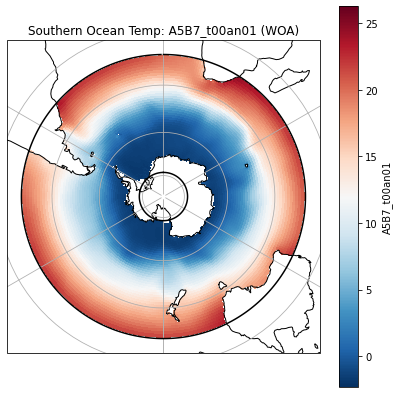

In [12]:
rangeMeanSurfaceTempWOA(dfWOALatCmean, 1)

Plot of WOA statistical mean surface temperature data for 2005 - 2017.

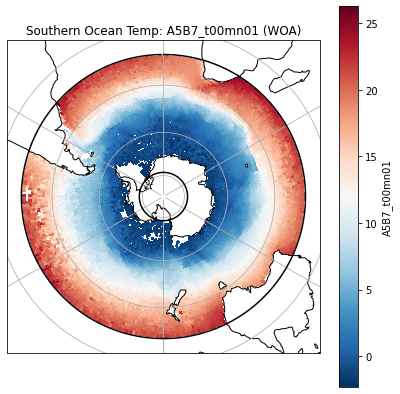

In [13]:
rangeMeanSurfaceTempWOA(dfWOALatSmean, 1)

<br>

#### Comparison Plots